In [30]:
import os
import tensorflow as tf

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [32]:
directory=r"C:\Users\PythonTeam\Desktop\BALAJI\BALAJI\DL Projects\Multi-Fruit_Classification_and_Grading_Using_a_Same-Domain_Transfer_Learning_Approach\Processed Images_Fruits"
train_dir=os.path.join(directory,'Train')
validation_dir=os.path.join(directory,'Validation')

In [33]:
Image_height,Image_width=224,224
Batch_size=32
Epochs=10

In [34]:
train_datagenerator=ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [35]:
train_generator=train_datagenerator.flow_from_directory(
    directory,
    target_size=(Image_height,Image_width),
    batch_size=Batch_size,
    class_mode='categorical',
    subset='training')

Found 15623 images belonging to 3 classes.


In [36]:
validation_generator=train_datagenerator.flow_from_directory(
    directory,
    target_size=(Image_height,Image_width),
    batch_size=Batch_size,
    class_mode='categorical',
    subset='validation')

Found 3903 images belonging to 3 classes.


In [37]:
def create_model(model):
    model.trainable=True
    x=model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x)
    x=Dropout(0.5)(x)
    output_layer=Dense(3,activation='softmax')(x)
    models=Model(inputs=model.input,outputs=output_layer)
    return models

In [38]:
mode={
    'NASNetMobile':NASNetMobile(weights='imagenet',include_top=False,input_shape=(Image_height,Image_width,3))}

In [39]:
results={}
for name,base_model in mode.items():
    print(f"Training {name}...")
    model=create_model(base_model)
    model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
    Max=model.fit(
        train_generator,
        epochs=Epochs,
        validation_data=validation_generator,
        verbose=1,
        callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,min_lr=1e-6)])
    loss, accuracy = model.evaluate(validation_generator)
    print(f"{name} - Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    results[name] = accuracy

Training NASNetMobile...
Epoch 1/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1844s 4s/step - accuracy: 0.9057 - loss: 0.2441 - val_accuracy: 0.6229 - val_loss: 1.3377 - learning_rate: 1.0000e-04
Epoch 2/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1617s 3s/step - accuracy: 0.9889 - loss: 0.0327 - val_accuracy: 0.5532 - val_loss: 1.7199 - learning_rate: 1.0000e-04
Epoch 3/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1454s 3s/step - accuracy: 0.9944 - loss: 0.0166 - val_accuracy: 0.5993 - val_loss: 1.7280 - learning_rate: 1.0000e-04
Epoch 4/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1792s 4s/step - accuracy: 0.9963 - loss: 0.0116 - val_accuracy: 0.6118 - val_loss: 2.5249 - learning_rate: 1.0000e-04
Epoch 5/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 2022s 4s/step - accuracy: 0.9977 - loss: 0.0055 - val_accuracy: 0.6249 - val_loss: 2.4413 - learning_rate: 2.0000e-05
Epoch 6/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1525s 3s/step - accuracy: 0.9980 - loss: 0.0056 - val_accuracy: 0.6264 - val_loss: 2.4860 - learning_rate: 2.0000e-05
Epoch 7/10
489/489 ━━━━━━━━

In [40]:
val_generator = validation_generator
val_generator.reset()
predictions = model.predict(val_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

122/122 ━━━━━━━━━━━━━━━━━━━━ 114s 859ms/step


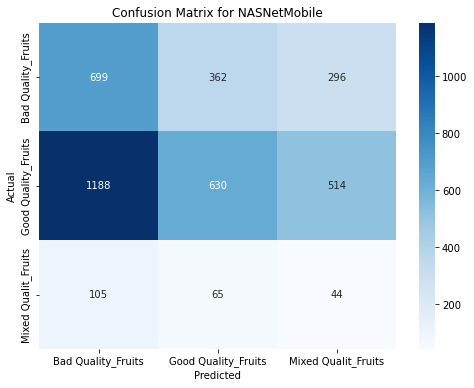

In [42]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title(f"Confusion Matrix for {name}")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [43]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_414      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation_414[0… │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_415      │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_417      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_415[0… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_417[0… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_416      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_418      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_416[0

 Total params: 15,992,003 (61.00 MB)

 Trainable params: 5,318,421 (20.29 MB)

 Non-trainable params: 36,738 (143.51 KB)

 Optimizer params: 10,636,844 (40.58 MB)

In [44]:
model.save(f"{name}_fruit_classification.h5")